# 1. Import packages

In [ ]:
#Import packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import forecast
import statlearning
import statsmodels as sm
import statsmodels.api as smt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

# 2. Import Training data

In [ ]:
#Import Train data
data = pd.read_csv('Covid_19_train.csv', index_col='Time', parse_dates=True, dayfirst=True)

# 3. Exploratory data analysis

In [ ]:
#Inspect the first 5 columns of the time series
data.head()

,Daily_cases
Time,
2020-02-29,1.0
2020-03-01,9.0
2020-03-02,3.0
2020-03-03,9.0
2020-03-04,16.0


The head indicates that this time series present the start of an outbreak cycle.

In [ ]:
#Inspect the last 5 columns of the time series
data.tail()

,Daily_cases
Time,
2020-09-16,1266.0
2020-09-17,1475.0
2020-09-18,1540.0
2020-09-19,1582.0
2020-09-20,1213.0


The tail further indicates that the outbreak level is relatively high, perhaps at a peak or on an increasing trend.

In [ ]:
#Define the y-variable
y = data['Daily_cases'].copy()
y.index = y.index.to_period(freq='D')

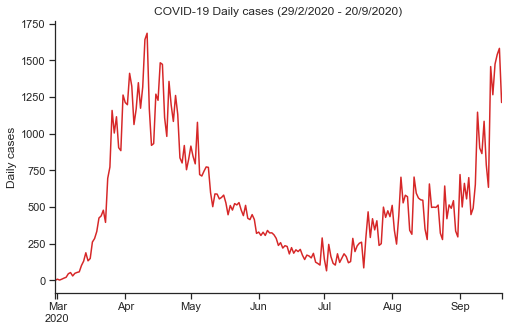

In [ ]:
#Plot the data
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Daily cases')
ax.set_title('COVID-19 Daily cases (29/2/2020 - 20/9/2020)')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

#### From initial observation: 
- Data is not stationary, represented by different peaks, troughs and random fluctuations. 
- Data is believed to be exposed to small seasonal effects as represented by repeated cycles. This is further supported by underlying knowledge of a relative relationship between the coronavirus and the different seasons in a country. Since this is a 6-month data, it is possible to represent more than 1 season within a year and thus, possible seasonal effects on COVID-19.
- Original data contains large values which undermine numerical stability.
- Data is exposed to high variations around the peak of an outbreak. 

###### Thus, at this stage, next suggested actions include: 
1. Time series decomposition to remove seasonal effects. 
2. Formal stationarity tests on seasonally adjusted time series (if chosen) to decide the appropriateness of this data as an input of ARIMA model. 
3. If stationarity is not achieved in the original time series or seasonally adjusted time series, further transformation include log-transformation or differencing is suggested to obtain an appropriate model.

##### Reasons for choosing ARIMA model: 
1. Random walk method is a naive, simple method is more suitable for a 1-step ahead forecast than multiple-step ahead. This is further supported by the fact that the forecast will ultimately be the conditional mean, given data up to time t. 


2. Simple exponential smoothing is not chosen since it is more suitable for time series with changing levels only. This is again, relatively simple and ultimately, this will convert forecast to conditional mean, given data up to time t.


3. Trend corrected exponential smoothing is not chosen as well due to its lack of accountability towards seasonal components while there indicates seasonal components in this time series. By its name, this method only forecasts the "trend" of the future which is lack of precisions.


4. While Holts Winters Smoothing resolve the limitation of method 3, it is still not suitable enough for this time series. This is due to the observation of this time series having inconsistent seasonal trends, combining with changing levels. Thus, this time series is not suitable for additive and multiplicative smoothings where these are more appropriate for consistent variations of seasonal component. 


5. While ARMA has the greatest advantage in applying both the autoregressive process (AR) and dealing with moving averages (MA), it can only be dealth with stationary time series which calls for transformation before using this method. 


6. ARIMA is the best out of all mentioned models since this can be applied directly on nonstationarity time series, as long as differencing orders are specified within the model. This model does not only account for the effects of past data up to time t but also random shocks (irregular components) in real life situation, making it the most flexible model. In addition, this method has weighted moving averages, meaning that the fact of past shocks/unpredictable events with commonly less effects on future predictions will all be taken into account. This model's invertibility also further highlights the logical aspect of the model. In general, ARIMA provides the greatest flexibility that accounts for a reasonable number of aspects of this time series, thus, this model unsurprisingly chosen for forecasting!

# 4. Variable selection

## 4.1 Time series decomposition

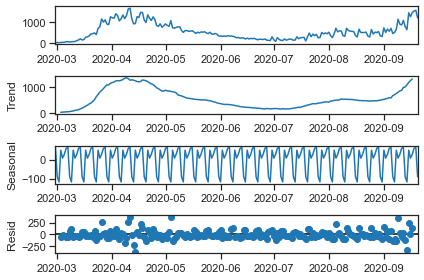

In [ ]:
#Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import DecomposeResult

decomposition = seasonal_decompose(data, model='additive') 
decomposition_result = DecomposeResult.plot(decomposition)

There observes a clear trend of seasonality throughout the time series. This suggests removing the seasonal effects to obtain a seasonally adjusted time series.

In [ ]:
#Seasonally adjusted time series
seasonally_adj_ts = (decomposition.trend + decomposition.resid)

seasonally_adj_ts

Time
2020-02-29            NaN
2020-03-01            NaN
2020-03-02            NaN
2020-03-03     -40.394843
2020-03-04       8.462300
                 ...     
2020-09-16    1258.462300
2020-09-17    1447.565748
2020-09-18            NaN
2020-09-19            NaN
2020-09-20            NaN
Length: 205, dtype: float64

A certain number of daily cases were identified as the result of a seasonal component, thus, removing seasonal components leave certain emty data within the current time series, identified as "NaN". This empty values should be removed to avoid problems when implementing other functions.

In [ ]:
#Remove missing values from seasonally adjusted time series
seasonally_adj_ts = seasonally_adj_ts.dropna()

seasonally_adj_ts

Time
2020-03-03     -40.394843
2020-03-04       8.462300
2020-03-05      -5.434252
2020-03-06     -13.048608
2020-03-07     -10.120036
                 ...     
2020-09-13     877.828943
2020-09-14     752.706494
2020-09-15    1408.605157
2020-09-16    1258.462300
2020-09-17    1447.565748
Length: 199, dtype: float64

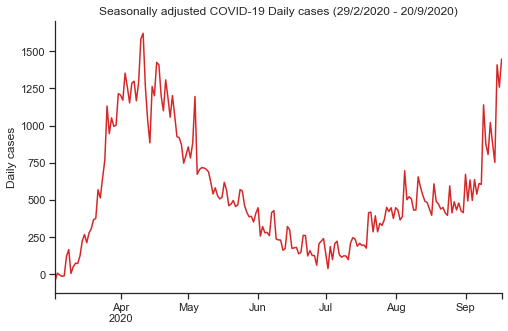

In [ ]:
#Plot the seasonally adjusted time series
fig, ax= plt.subplots(figsize=(8,5))
seasonally_adj_ts.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Daily cases')
ax.set_title('Seasonally adjusted COVID-19 Daily cases (29/2/2020 - 20/9/2020)')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

In [ ]:
#Convert the time Series into a DataFrame for clear observation
seasonally_adj_ts = pd.DataFrame(seasonally_adj_ts, columns=['Daily_cases'])

seasonally_adj_ts

,Daily_cases
Time,
2020-03-03,-40.394843
2020-03-04,8.462300
2020-03-05,-5.434252
2020-03-06,-13.048608
2020-03-07,-10.120036
...,...
2020-09-13,877.828943
2020-09-14,752.706494
2020-09-15,1408.605157


## 4.2 Inspect stationarity

In [ ]:
#Define formula to evaluate stationarity
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Daily_cases'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

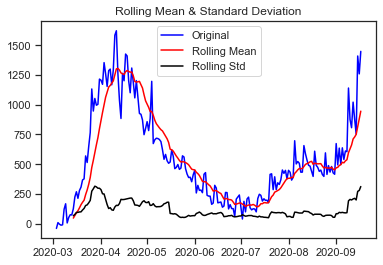

ADF Statistic: -2.1772998841328817
p-value: 0.21458719393242615
Critical Values:
	1%: -3.465811691080702
	5%: -2.877123351472649
	10%: -2.5750770662586864


In [ ]:
#Inspect stationarity of seasonally adjusted time series
get_stationarity(seasonally_adj_ts)

With chosen alpha = 0.05, p-value of ADF statistics = 0.21 > 0.05 clearly indicate H0 rejection, reflecting that this time series is NOT STATIONARY.

As outlined above, this time series will undergo log-transformation below to stabilise the variance in hope of achieving stationarity.

In [ ]:
#Log-transformation of Seasonally adjusted time series
log_ssa_data = np.log(seasonally_adj_ts)
log_ssa_data = pd.DataFrame(log_ssa_data).dropna()

log_ssa_data

,Daily_cases
Time,
2020-03-04,2.135621
2020-03-08,4.794376
2020-03-09,5.116235
2020-03-10,1.723687
2020-03-11,3.940850
...,...
2020-09-13,6.777452
2020-09-14,6.623675
2020-09-15,7.250355


Since a few values before log-transformation were negative, these have created further missing values within the log-transformed time series. Again, these will be remove to remain the validity of the time series. The time series is left with 195 values for training data.

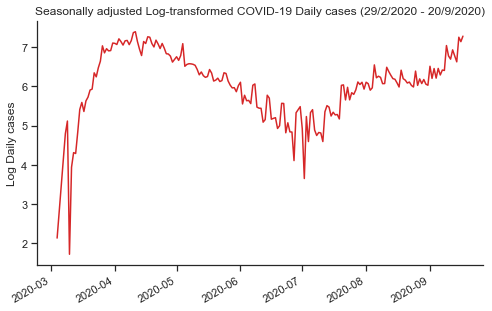

In [ ]:
#Plot Seasonally adjusted log-transformed time series
fig, ax= plt.subplots(figsize=(8,5))
log_ssa_data['Daily_cases'].plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log Daily cases')
ax.set_title('Seasonally adjusted Log-transformed COVID-19 Daily cases (29/2/2020 - 20/9/2020)')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

Some levels of this plot clearly show improved stationarity, however, there still exists overall up and down trends through the time series, suggesting that stationarity is still not satisfied for fitting and forecasting. This can be further formally confirmed using Dickey-Fuller test below.

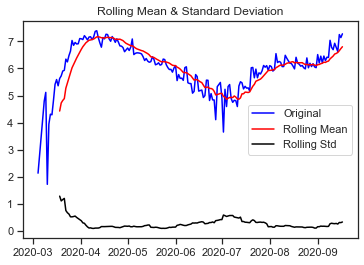

ADF Statistic: -1.8323334891730463
p-value: 0.3645312357198721
Critical Values:
	1%: -3.466598080268425
	5%: -2.8774669520682674
	10%: -2.5752604356654425


In [ ]:
#Inspect Seasonally adjusted log-transformed time series
get_stationarity(log_ssa_data)

Again, at the significance level 5%, p-value of ADF statistic for this time series indicates H0 rejection an conclude that the time series is NOT STATIONARY.

As outlined above, next transformation will be 1st-order differencing.

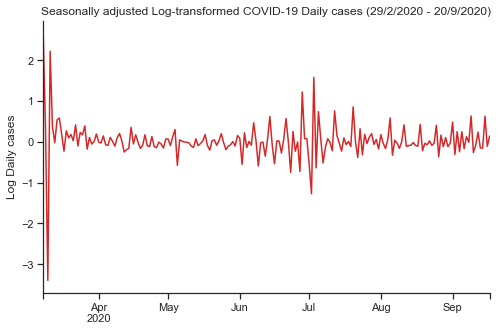

In [ ]:
#1st order differencing of Seasonally adjusted Log-transformed time series
ssa_log_shift = log_ssa_data - log_ssa_data.shift()
ssa_log_shift.dropna(inplace=True)

#Plot 1st order differencing of Seasonally adjusted Log-transformed time series
fig, ax= plt.subplots(figsize=(8,5))
ssa_log_shift['Daily_cases'].plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log Daily cases')
ax.set_title('Seasonally adjusted Log-transformed COVID-19 Daily cases (29/2/2020 - 20/9/2020)')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

This plot definitely has shown significantly improved stationarity level but again, will be evaluate using ADF statistics.

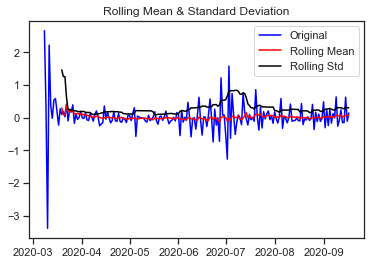

ADF Statistic: -4.390117253139581
p-value: 0.0003090175741221952
Critical Values:
	1%: -3.466598080268425
	5%: -2.8774669520682674
	10%: -2.5752604356654425


In [ ]:
#Stationarity evaluation of 1st order differencing of Seasonally adjusted Log-transformed time series
get_stationarity(ssa_log_shift)

As expected, the ADF statistic is extremely closed to the critical value while p-value performs exceptionally well. P-value is a lot lower than alpha = 0.05 which strongly indicates that the time series is STATIONARY. 

Additionally, the parallel lines of the rolling mean and rolling standard deviation further confirms STATIONARITY of the time series.

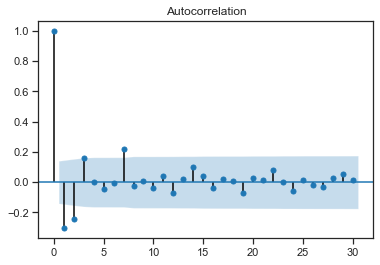

In [ ]:
#Inspect ACF
ACF = smt.graphics.tsa.plot_acf(ssa_log_shift, lags=30, alpha = 0.05)

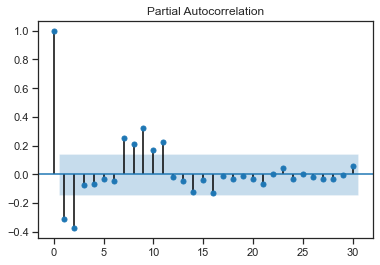

In [ ]:
#Inspect PACF
smt.graphics.tsa.plot_pacf(ssa_log_shift, lags=30, alpha=0.05)
plt.show()

The ACF plot seems to die down after lag 1 while PACF seems to cut down after lag 3 which again, evidenced the stationarity of the time series. 

-> These findings also suggest that ARIMA model of d = 1 can now be applied upon Seasonally adjusted log-transformed time series. q and p orders should be further evaluated using AIC or BIC on 1st-order differenced log seasonally adjusted time series.

In [ ]:
import statsmodels.tsa.stattools as st 

#AIC to select orders (p,q)
order = st.arma_order_select_ic(ssa_log_shift,max_ar=3,max_ma=3,ic=['aic'])
order

{'aic':             0           1           2           3
 0  255.939967  206.404282  208.335074  186.032148
 1  234.970619  208.382561  192.700233  161.851186
 2  191.523963  193.427738  195.047679  193.231577
 3  193.445018  195.171519  187.910847  194.039286,
 'aic_min_order': (1, 3)}

In [ ]:
#BIC to select orders (p,q)
order = st.arma_order_select_ic(ssa_log_shift,max_ar=3,max_ma=3,ic=['bic'])
order

{'bic':             0           1           2           3
 0  262.475684  216.207857  221.406506  202.371439
 1  244.774193  221.453994  209.039524  181.458334
 2  204.595396  209.767029  214.654828  216.106584
 3  209.784309  214.778668  210.785854  220.182151,
 'bic_min_order': (1, 3)}

Since AIC and BIC point to different pairs of (p,q) where specifically, AIC pointed to (1,3) and BIC pointed to (1,3), both of these models will be fitted and evaluated to determine the best training model.

# 5. ARIMA FIT

In [ ]:
# Import ARIMA class
from statsmodels.tsa.arima_model import ARIMA

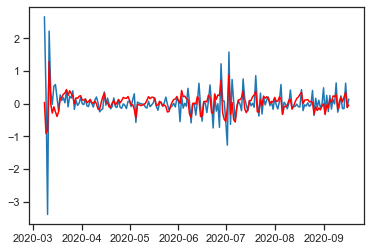

In [ ]:
#Define the mode, data and orders
model = ARIMA(log_ssa_data, order=(1,1,3))

#Fit ARIMA (1,1,3) on train data
results = model.fit(disp=-1)

#Generate outputs of the ARIMA fit
results_values = results.fittedvalues

#Plot ARIMA fit vs. actual 1st-order differencing of seasonally adjusted, log-transformed time series
plt.plot(ssa_log_shift)
plt.plot(results_values, color='red')

From ultimate goal of forecasting, the ARIMA fit seems to have well captured the major trends of the time series without over capturing the minor trends, preventing possibility of an underfitted test model. However, further validation can be judged through residuals plot and evaluation statistics. 

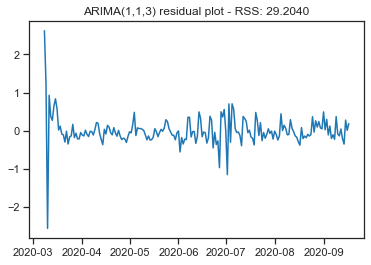

In [ ]:
#Residuals plot of fitted ARIMA model
residuals_AIC = pd.DataFrame(results.resid)

plt.figure()
plt.plot(residuals_AIC)
plt.title('ARIMA(1,1,3) residual plot - RSS: %.4f'% sum((results.resid.values)**2))
plt.show()

In [ ]:
#Residuals variance
resids_var = np.var(residuals_AIC)
resids_var

0    0.150499
dtype: float64

In [ ]:
#Residuals mean
resids_mean = np.mean(residuals_AIC)
resids_mean

0   -0.006108
dtype: float64

Variance and Mean of errors both have values close to 0, strongly satisfy the expectation of a good fitting model. 

In [ ]:
#Train model Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Train MSE
train_mse = mean_squared_error(ssa_log_shift,results_values)
print('Train errors (MSE):',train_mse)

#Train RMSE
train_rmse = np.sqrt(mean_squared_error(ssa_log_shift,results_values))
print('Train RMSE:',train_rmse)

#Train r-squared
train_r2 = r2_score(ssa_log_shift,results_values)
print('Train R-squared:',train_r2)

Train errors (MSE): 0.150535992490594
Train RMSE: 0.38798968090735864
Train R-squared: 0.2983605635820785


In [ ]:
#Results summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Daily_cases   No. Observations:                  194
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 -74.926
Method:                       css-mle   S.D. of innovations              0.349
Date:                Sat, 13 Nov 2021   AIC                            161.851
Time:                        00:00:50   BIC                            181.458
Sample:                             1   HQIC                           169.791
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0370      0.032      1.157      0.247      -0.026       0.100
ar.L1.D.Daily_cases     0.9265      0.032     29.253      0.000       0.864       0.989
ma.L1.D.Daily_cases    -1.6854      0.107    -15.699      0.000      -1.896      -1.475
ma.L2.D.Daily_cases     0.5501      0.196      2.812      0.005       0.167       0.933
ma.L3.D.Daily_cases     0.2342      0.101      2.314      0.021       0.036       0.433
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0793           +0.0000j            1.0793            0.0000
MA.1            0.9601           -0.2802j            1.0001           -0.0452
MA.2            0.9601           +0.2802j            1.0001            0.0452
MA.3           -4.2695           -0.0000j            4.2695           -0.5000
-----------------------------------------------------------------------------
"""

### Evaluation of ARIMA fit on Train data:

The low p-values of each parameter on the model, except for the intercept indicate that these coefficient are exceptionally well fitted for this model, with some p-values go as low as 0.000. While this is a good indicator for explaining the train data, this fact might underline a possibility of underfitted testing model.

In addition, train errors (MSE) and train RMSE being close to 0 indicate a well-fitted training model. 

While r-squared indicates that the fitted model only captures 29.8% of the orginal model, by taking into account the low train MSE and RMSE, it is believed that this is a reasonable r-squared value. This is based on the fact that a too high r-squared value might determine overfitting of the train data while underfitting of the test data and vice versa. Thus, r-squared = 29.8% is judged to reflect reasonable fit of train data and hopefully, will predict test data "just-right".

# 6. ARIMA FORECAST

,Daily_cases forecast
2020-09-21,1295.0
2020-09-22,1300.0
2020-09-23,1366.0
2020-09-24,1434.0
2020-09-25,1504.0
2020-09-26,1576.0
2020-09-27,1650.0
2020-09-28,1727.0
2020-09-29,1806.0
2020-09-30,1888.0


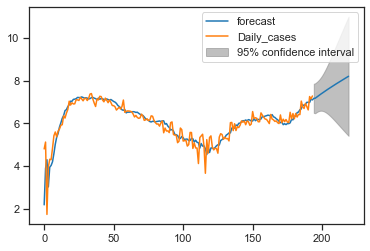

In [ ]:
#FORECAST

#Set forecasting dates
dates=pd.date_range(start='21-09-2020', periods=15, freq='D')

#Plot forecast
final_prediction = results.plot_predict(1,220)

#Numerical forecast
output = results.forecast(steps=15)
yhat = output[0]
final_yhat = np.exp(yhat)

#Convert final_yhat into DataFrame format
final_yhat = pd.DataFrame(final_yhat.round(0), columns=['Daily_cases forecast'], index=dates)

final_yhat

### Observations of ARIMA forecast model

Forecast outputs of daily cases for the next 15 days seem to have an increasing trend with a few small peaks and troughs between the trend. This forecast seems to be reasonable, however, by assessing the fact that the training model has been a little "well-fitted", there is a reasonable possibility that the forecasting outputs are over estimated, outlining certain limitations.

In addition, since forecast was made on log-scaled time series, the final outputs converted back to normal scale might also have been inflated. This hypothesis can be observed in the last 5 forecasted values being relatively high compared to the start of the forecasting period, representing further barriers of the analysis. Intuitively, while it is possible for this forecast to be true, it is also quite unlikely for an outbreak to spread at a range of approximately 1000 cases in the span of 15 days. However, based on general underlying knowledge, COVID-19 is a pandemic that has never occurred before, thus, effects on different countries vary largely depending on their economical and social levels. 

Furthermore, other limitations include having to drop certain missing values due to removal of seasonal components, log-transformation and 1st-order differencing. Until the fitting stage, the model is left with only 195 values compared to 205 values in the raw dataset, thus, can lower fitting and predicting accuracy of the analysis.

However, the final decisions regarding model effectiveness will be assessed numerically through Mean Squared Error of the forecast model, along with Root Mean Squared Error and R-squared values below.

# 7. FORECAST EVALUATION

In [ ]:
#FORECAST EVALUATION
import pandas as pd

#Import Test data
covid_19_test = pd.read_csv('Covid_19_test.csv',index_col='Time',parse_dates=True, dayfirst=True)

#Test MSE
test_error = mean_squared_error(covid_19_test,final_yhat)
print('Test error (MSE):',test_error)

#Test RMSE
test_rmse = np.sqrt(test_error)
print('Test RMSE:',test_rmse)

#Test r-squared
test_r2 = r2_score(covid_19_test,final_yhat)
print('Test R-squared:',test_r2)

Test error (MSE): 3184968.6666666665
Test RMSE: 1784.648051204121
Test R-squared: 0.0
